# Customer Churn Exploratory Analysis

This notebook explores customer churn patterns using a unified, analytics-ready feature table engineered in SQL.

The objectives are:
- Validate SQL-engineered churn features
- Understand behavioral differences between churned and retained customers
- Identify actionable churn signals related to engagement, support friction, and tenure

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.float_format", "{:.2f}".format)
sns.set_style("whitegrid")

In [2]:
df = pd.read_csv("churn_features.csv")
df.head()

,customer_id,is_churned,final_churn_date,num_subscriptions,tenure_days,total_orders,total_revenue,post_churn_order_flag,total_tickets,tickets_last_30d_pre_churn,tickets_last_7d_pre_churn,has_post_churn_ticket_flag,total_events,events_last_30d_pre_churn,events_last_7d_pre_churn,post_churn_engagement_flag
0,1545,1,2022-09-09,3.00,616.00,20,485.49,1,1,0.00,0.00,0,170,0.00,0.00,0
1,2788,0,NaN,1.00,2914268.00,49,5176.85,0,0,0.00,0.00,0,1,0.00,0.00,0
2,4363,0,NaN,1.00,2914268.00,49,1735.58,0,2,0.00,0.00,0,1,0.00,0.00,0
3,5057,1,2024-07-01,2.00,1277.00,42,2044.07,1,5,0.00,0.00,0,2,0.00,0.00,0
4,5403,1,2021-09-28,1.00,270.00,10,170.40,1,5,0.00,0.00,0,1,0.00,0.00,0


In [3]:
df.shape

(25000, 16)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   customer_id                 25000 non-null  int64  
 1   is_churned                  25000 non-null  int64  
 2   final_churn_date            13611 non-null  object 
 3   num_subscriptions           24991 non-null  float64
 4   tenure_days                 24991 non-null  float64
 5   total_orders                25000 non-null  int64  
 6   total_revenue               25000 non-null  float64
 7   post_churn_order_flag       25000 non-null  int64  
 8   total_tickets               25000 non-null  int64  
 9   tickets_last_30d_pre_churn  25000 non-null  float64
 10  tickets_last_7d_pre_churn   25000 non-null  float64
 11  has_post_churn_ticket_flag  25000 non-null  int64  
 12  total_events                25000 non-null  int64  
 13  events_last_30d_pre_churn   250

In [5]:
df.isna().sum()

customer_id                       0
is_churned                        0
final_churn_date              11389
num_subscriptions                 9
tenure_days                       9
total_orders                      0
total_revenue                     0
post_churn_order_flag             0
total_tickets                     0
tickets_last_30d_pre_churn        0
tickets_last_7d_pre_churn         0
has_post_churn_ticket_flag        0
total_events                      0
events_last_30d_pre_churn         0
events_last_7d_pre_churn          0
post_churn_engagement_flag        0
dtype: int64

No unexpected missing values in dataset.
Feature table is modeling-ready.

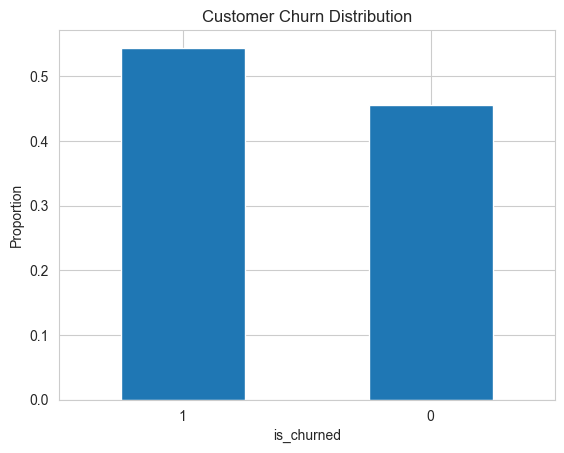

In [6]:
# Churn distribution
churn_dist = df["is_churned"].value_counts(normalize=True)

churn_dist.plot(kind="bar")
plt.title("Customer Churn Distribution")
plt.ylabel("Proportion")
plt.xticks(rotation=0)
plt.show()

Approximately 54% of customers churn over the observed lifecycle, providing a balanced dataset suitable for churn analysis and modeling.

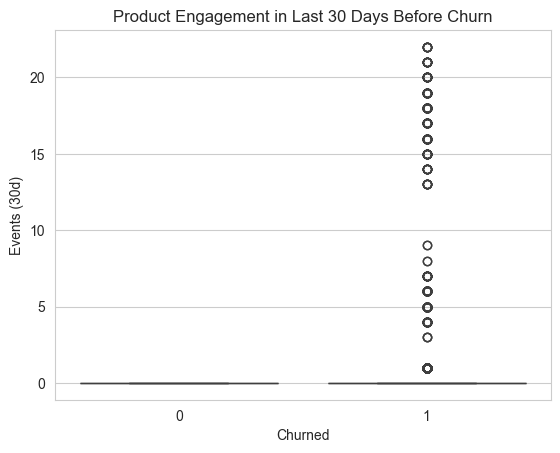

In [9]:
# Engagement before churn - 30 days
sns.boxplot(
    data=df,
    x="is_churned",
    y="events_last_30d_pre_churn"
)
plt.title("Product Engagement in Last 30 Days Before Churn")
plt.xlabel("Churned")
plt.ylabel("Events (30d)")
plt.show()

Churned customers show sharply lower engagement in the final 30 days before churn, validating engagement decay as a leading churn indicator.


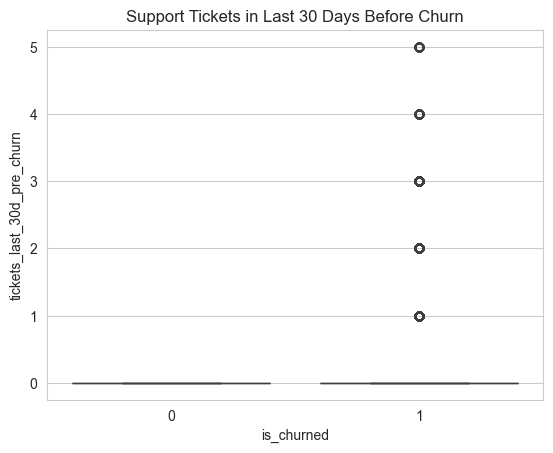

In [11]:
# Support tickets before churn - 30 days
sns.boxplot(
    data=df,
    x="is_churned",
    y="tickets_last_30d_pre_churn"
)
plt.title("Support Tickets in Last 30 Days Before Churn")
plt.show()

While engagement declines before churn, support activity remains present, indicating unresolved friction or billing issues close to churn.

In [12]:
# Combined Signal: Engagement × Support

df["low_engagement"] = df["events_last_30d_pre_churn"] <= 1
df["has_tickets"] = df["tickets_last_30d_pre_churn"] >= 1

combo = (
    df.groupby(["low_engagement", "has_tickets"])["is_churned"]
      .mean()
      .reset_index()
)

combo


,low_engagement,has_tickets,is_churned
0,False,False,1.00
1,False,True,1.00
2,True,False,0.48
3,True,True,1.00


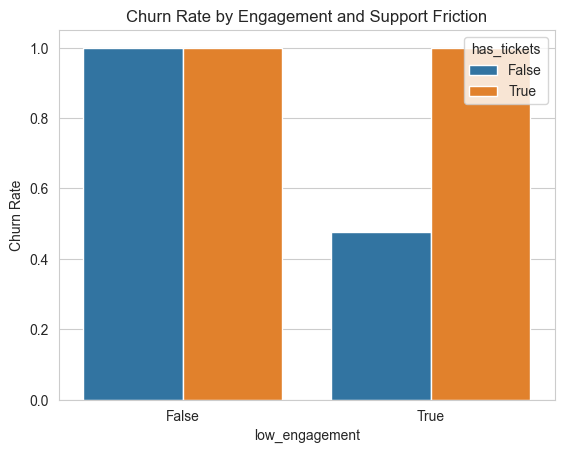

In [13]:
sns.barplot(
    data=combo,
    x="low_engagement",
    y="is_churned",
    hue="has_tickets"
)
plt.title("Churn Rate by Engagement and Support Friction")
plt.ylabel("Churn Rate")
plt.show()


The highest churn rates occur among customers with low engagement and recent support tickets, highlighting a powerful interaction between disengagement and friction.

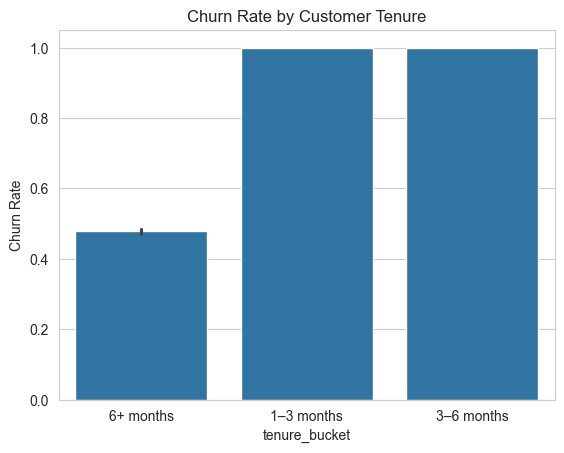

In [14]:
# Tenure vs. Churn
def tenure_bucket(days):
    if days < 30:
        return "< 1 month"
    elif days < 90:
        return "1–3 months"
    elif days < 180:
        return "3–6 months"
    else:
        return "6+ months"

df["tenure_bucket"] = df["tenure_days"].apply(tenure_bucket)

sns.barplot(
    data=df,
    x="tenure_bucket",
    y="is_churned"
)
plt.title("Churn Rate by Customer Tenure")
plt.ylabel("Churn Rate")
plt.show()


Churn is heavily front-loaded, with significantly higher churn among short-tenure customers, emphasizing the importance of onboarding and early engagement.

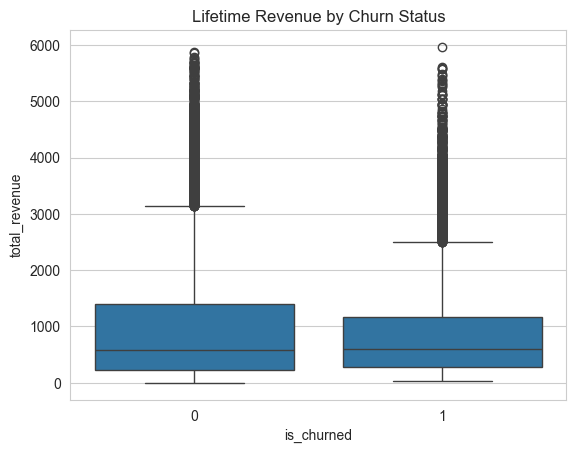

In [15]:
# Revenue vs. Churn
sns.boxplot(
    data=df,
    x="is_churned",
    y="total_revenue"
)
plt.title("Lifetime Revenue by Churn Status")
plt.show()


Retained customers generate higher lifetime revenue despite fewer orders, suggesting that plan tier and pricing power outweigh transaction frequency.

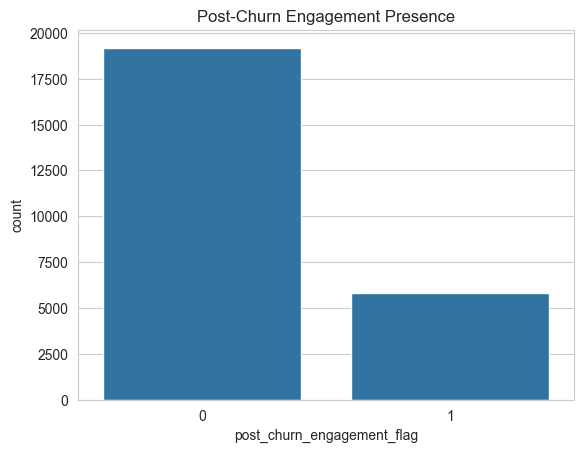

In [16]:
# Post-Churn Engagement
sns.countplot(
    data=df,
    x="post_churn_engagement_flag"
)
plt.title("Post-Churn Engagement Presence")
plt.show()


A meaningful subset of churned customers (~5.8k) continues to engage after cancellation, indicating potential reactivation or win-back opportunities.

## Key Takeaways

- Churn is strongly preceded by declining product engagement.
- Support friction remains present near churn, even as usage drops.
- The combination of low engagement and support activity yields the highest churn risk.
- Early-tenure customers are significantly more likely to churn.
- Post-churn engagement suggests opportunities for reactivation strategies.
